In [1]:
%%capture
!pip install xbatcher tensorboard imbalanced-learn

In [2]:
import os
if 'notebooks' in os.getcwd():
    os.chdir("..")

import util
import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

# If we have gpu available, use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
torch.set_default_device(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu



Prepare data

In [3]:
ds = xr.open_dataset("data_working/westmort.nc")\
    .squeeze(drop=True)\
    .drop_vars("spatial_ref")

In [4]:
# Use EWMA to smooth mortality observations
ds["mort_ewma"] = xr.apply_ufunc(
    util.manip.numpy_ewma_vectorized,
    ds.mortality,
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    kwargs=dict(window=3)
)

In [5]:
# Calculate total basal area based on all the genus rasters
ba_vars = ["abies", "picea", "populus", "tsuga", "pseudotsuga"]
ds["forest_ba"] = ds[ba_vars].to_stacked_array("band", sample_dims=["x", "y", "time"]).sum(dim="band")

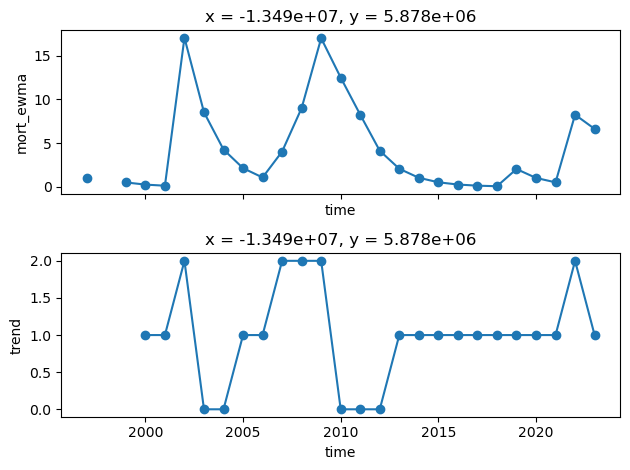

In [6]:
# Reclassify target based on its trend. Recovery (decreasing), static (within cutoff), damage (increasing).
cutoff = 2.5

ds["diff"]  = ds["mort_ewma"].diff("time")

# Shift trend to [0, 2] for compatability with torch
ds["trend"] = np.sign(ds["diff"]) * (np.abs(ds["diff"]) > cutoff) + 1

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

x, y = 100, 100
ds.isel(x=x, y=y).mort_ewma.plot(ax=ax1, marker='o')
ds.isel(x=x, y=y).trend.plot(ax=ax2, marker='o')

fig.tight_layout()
plt.show()

In [7]:
ds = ds.to_stacked_array("band", sample_dims=["x", "y", "time"])\
    .transpose("time", "band", ...)
ds

<xarray.DataArray 'abies' (time: 27, band: 20, y: 652, x: 590)> Size: 831MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * time      (time) int64 216B 1997 1998 1999 2000 2001 ... 2020 2021 2022 2023
  * x         (x) float64 5kB -1.389e+07 -1.389e+07 ... -1.154e+07 -1.154e+07
  * y         (y) float64 5kB 6.278e+06 6.274e+06 ... 3.678e+06 3.674e+06
  * band      (band) object 160B MultiIndex
  * variable  (band) <U11 880B 'abies' 'picea' 'populus' ... 'diff' 'trend'

Make sure windowing works right

In [8]:
window = dict(x=[8, False], y=[8, False], time=[5, False])
mort_arr = ds.sel(band="trend", drop=True)
mort_ds = util.datasets.WindowXarrayDataset(ds, window, mask=mort_arr)

print(len(mort_ds))

82584


In [9]:
eg_window = mort_ds[10]
window_x = eg_window.isel(time=slice(None, -1))
window_y = eg_window.isel(time=-1).sel(band="trend")

In [10]:
assert not np.any(np.isnan(window_y.values))

Set up model definition

In [11]:
ds.band

<xarray.DataArray 'band' (band: 20)> Size: 160B
array([('abies',), ('picea',), ('populus',), ('pseudotsuga',), ('tsuga',),
       ('vod',), ('elev',), ('slope',), ('northness',), ('eastness',),
       ('fire',), ('mortality',), ('prcp',), ('vp',), ('tmin',),
       ('treecover',), ('mort_ewma',), ('forest_ba',), ('diff',), ('trend',)],
      dtype=object)
Coordinates:
  * band      (band) object 160B MultiIndex
  * variable  (band) <U11 880B 'abies' 'picea' 'populus' ... 'diff' 'trend'

In [12]:
reload(util.convlstm)
from util.convlstm import ClassifierConvLSTM

input_bands = ["fire", "mort_ewma", "prcp", "elev", "treecover", "forest_ba", "vp", "tmin"]
input_inds = np.where(np.isin(ds.coords.get("variable").values, input_bands))[0]
input_channel = len(input_bands)
hidden_dim = 8
num_layers = 2
kernel = (3, 3)
n_classes = 3

m = ClassifierConvLSTM(input_channel, hidden_dim, n_classes, kernel, num_layers, batch_first=True)

Verify that the shapes work out.

In [13]:
fake_input = torch.tensor(window_x.isel(band=input_inds).values).unsqueeze(0).to(torch.float32)
fake_output = m(fake_input)
# Since we are doing classification now, these shapes should not match. See the docs
# for torch.nn.CrossEntropyLoss
print("Output shape:", fake_output.shape)
print("Window output shape:", window_y.shape)

Output shape: torch.Size([1, 3, 8, 8])
Window output shape: (1, 8, 8)


Data pipeline

In [14]:
# Prepare data laoders. Since we are using a 5-year lookback here, each dataset
# has to be temporally disjoint so we don't leak data. Since 2020 had very few
# surveys we have to ignore it.
years = ds.time.values

train_years = years[16:]
valid_years = years[:9]
test_years = years[9:16]

print("Training years:", train_years)
print("Validation years:", valid_years)
print("Testing years:", test_years)

Training years: [2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023]
Validation years: [1997 1998 1999 2000 2001 2002 2003 2004 2005]
Testing years: [2006 2007 2008 2009 2010 2011 2012]


In [15]:
valid_wds = util.datasets.WindowXarrayDataset(
    ds.sel(time=valid_years), window, 
    mask=mort_arr.sel(time=valid_years), 
)
test_wds  = util.datasets.WindowXarrayDataset(
    ds.sel(time=test_years), window, 
    mask=mort_arr.sel(time= test_years), 
)

print("Count of examples")
print("Validation:", len(valid_wds))
print("Testing:", len(test_wds))

Count of examples
Validation: 8209
Testing: 16670


In [16]:
from torch.utils.data import DataLoader

train_target_ind = np.where(ds.coords.get("variable").values == "trend")[0][0]
valid_target_ind = np.where(ds.coords.get("variable").values == "trend")[0][0]

dtype_x = torch.float32
dtype_y = torch.long

def make_collator(input_inds, target_ind):
    def collator(patch_list):
        X = torch.stack([
            torch.tensor(
                np.squeeze(patch.values[:-1, input_inds, :, :]),
                dtype=dtype_x
            )
            for patch in patch_list
        ])
    
        # Replace nan cells with the channel mean from this batch
        ch_mean = torch.nanmean(X, dim=0)
        X = torch.nan_to_num(X)
        X += ch_mean * torch.isnan(X)
        
        y = torch.stack([
            torch.tensor(patch.values[-1, target_ind, :, :], dtype=dtype_y)
            for patch in patch_list
        ]).squeeze(dim=2)
    
        return X, y

    return collator

train_collator = make_collator(input_inds, train_target_ind)
valid_collator = make_collator(input_inds, valid_target_ind)

batch_size = 32

# Setting the RNG to host device is necessary if we want to run on GPU
valid_loader = DataLoader(
    valid_wds, 
    batch_size, 
    shuffle=True, 
    collate_fn=valid_collator, 
    generator=torch.Generator(device=device)
)
test_loader  = DataLoader(
    test_wds, 
    batch_size, 
    shuffle=True, 
    collate_fn=valid_collator, 
    generator=torch.Generator(device=device)
)

In [17]:
# Again make sure the sizes work out
X, y = tuple(next(iter(valid_loader)))
print(X.shape)
out = m(X)
print(out.shape)

torch.Size([32, 4, 8, 8, 8])
torch.Size([32, 3, 8, 8])


In [19]:
import torchmetrics
from util.convlstm import ClassifierConvLSTM

train_ds = ds.sel(time=train_years)
wds = util.datasets.WindowXarrayDataset(
    train_ds, window, mask=mort_arr.sel(time=train_years)
)
print(f"N: {len(wds)}")

train_loader = DataLoader(
    wds, batch_size, 
    shuffle=True, collate_fn=train_collator, 
    generator=torch.Generator(device=device)
)

N: 17052


In [30]:
reload(util.training)
from util.training import BaseTrainer, ReduceLRMixin, EarlyStopMixin

# Masked loss is very slow for some reason
class Trainer(ReduceLRMixin, EarlyStopMixin, BaseTrainer):
    pass

In [35]:
# Model params
input_channel = len(input_bands)
hidden_dim = 4
num_layers = 2
kernel = (3, 3)
n_classes = 3
m = ClassifierConvLSTM(
    input_channel, 
    hidden_dim,
    n_classes,
    kernel, 
    num_layers, 
    batch_first=True,
    dropout=0.3
)

# Build trainer
# From exploring the data, recovery/damage are about 10x less common
# than stability.
loss = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0, 0.1, 1.0]))
opt  = torch.optim.Adam(m.parameters(), lr=0.005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3, factor=0.2)
metrics = util.training.get_classif_metrics("multiclass", n_classes)

model_name = f"03142025_ternaryconvlstm_small_dropout__weighted__8_8_5__8band"
logdir = os.path.join("logs", model_name)

# Remove existing logs if present
if os.path.exists(logdir):
    util.training.remove_log(logdir)

trainer = Trainer(
    m, opt, scheduler, loss, train_loader, valid_loader,
    metrics=metrics, 
    n_epochs=30,
    tensorboard_log=os.path.join(logdir, "history"),
    model_log=os.path.join(logdir, "model.pth"),
    defn_log=os.path.join(logdir, "model_definition.txt"),
    verbose=True,
    stop_patience=5,
    rel_improve=0.01
)

trainer.train()

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training loss:   0%|          | 0/533 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 1 of 30
                                  Key           Value
0                        LearningRate           0.005
1                          Loss/train        0.740117
2                          Loss/valid  tensor(0.6154)
3          MulticlassAccuracy()/train      0.79852897
4          MulticlassAccuracy()/valid       0.8517252
5  MulticlassAveragePrecision()/train       0.5420332
6  MulticlassAveragePrecision()/valid       0.5565601
7        MulticlassCohenKappa()/train      0.36784595
8        MulticlassCohenKappa()/valid      0.40727568



Training loss:   0%|          | 0/533 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 2 of 30
                                  Key           Value
0                        LearningRate           0.005
1                          Loss/train        0.636459
2                          Loss/valid  tensor(0.5852)
3          MulticlassAccuracy()/train       0.8097575
4          MulticlassAccuracy()/valid      0.84712285
5  MulticlassAveragePrecision()/train       0.5916018
6  MulticlassAveragePrecision()/valid        0.571846
7        MulticlassCohenKappa()/train       0.4099341
8        MulticlassCohenKappa()/valid      0.40580916



Training loss:   0%|          | 0/533 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 3 of 30
                                  Key           Value
0                        LearningRate           0.005
1                          Loss/train        0.618763
2                          Loss/valid  tensor(0.5876)
3          MulticlassAccuracy()/train       0.8055772
4          MulticlassAccuracy()/valid      0.83884495
5  MulticlassAveragePrecision()/train      0.59979326
6  MulticlassAveragePrecision()/valid      0.56075996
7        MulticlassCohenKappa()/train       0.4092068
8        MulticlassCohenKappa()/valid      0.38490075



Training loss:   0%|          | 0/533 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 4 of 30
                                  Key           Value
0                        LearningRate           0.005
1                          Loss/train        0.609844
2                          Loss/valid  tensor(0.6287)
3          MulticlassAccuracy()/train      0.80585945
4          MulticlassAccuracy()/valid      0.73284847
5  MulticlassAveragePrecision()/train      0.60542744
6  MulticlassAveragePrecision()/valid       0.5437916
7        MulticlassCohenKappa()/train      0.41234773
8        MulticlassCohenKappa()/valid       0.2511559



Training loss:   0%|          | 0/533 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 5 of 30
                                  Key           Value
0                        LearningRate           0.005
1                          Loss/train         0.60532
2                          Loss/valid  tensor(0.5947)
3          MulticlassAccuracy()/train       0.8060042
4          MulticlassAccuracy()/valid       0.7752333
5  MulticlassAveragePrecision()/train      0.60767907
6  MulticlassAveragePrecision()/valid      0.55950457
7        MulticlassCohenKappa()/train        0.412758
8        MulticlassCohenKappa()/valid      0.30617708



Training loss:   0%|          | 0/533 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 6 of 30
                                  Key           Value
0                        LearningRate           0.001
1                          Loss/train        0.601253
2                          Loss/valid  tensor(0.5993)
3          MulticlassAccuracy()/train       0.8055177
4          MulticlassAccuracy()/valid       0.8333974
5  MulticlassAveragePrecision()/train       0.6108496
6  MulticlassAveragePrecision()/valid      0.57341945
7        MulticlassCohenKappa()/train       0.4134149
8        MulticlassCohenKappa()/valid      0.38110703



Training loss:   0%|          | 0/533 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 7 of 30
                                  Key           Value
0                        LearningRate           0.001
1                          Loss/train        0.589137
2                          Loss/valid  tensor(0.5870)
3          MulticlassAccuracy()/train        0.810179
4          MulticlassAccuracy()/valid      0.82035536
5  MulticlassAveragePrecision()/train      0.61938095
6  MulticlassAveragePrecision()/valid      0.57199365
7        MulticlassCohenKappa()/train       0.4225747
8        MulticlassCohenKappa()/valid       0.3651327



Training loss:   0%|          | 0/533 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 8 of 30
                                  Key           Value
0                        LearningRate           0.001
1                          Loss/train        0.589465
2                          Loss/valid  tensor(0.5955)
3          MulticlassAccuracy()/train      0.80965024
4          MulticlassAccuracy()/valid       0.8172604
5  MulticlassAveragePrecision()/train      0.61972547
6  MulticlassAveragePrecision()/valid      0.56447804
7        MulticlassCohenKappa()/train      0.42251897
8        MulticlassCohenKappa()/valid      0.36026764



Training loss:   0%|          | 0/533 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 9 of 30
                                  Key           Value
0                        LearningRate           0.001
1                          Loss/train        0.592532
2                          Loss/valid  tensor(0.5883)
3          MulticlassAccuracy()/train       0.8088265
4          MulticlassAccuracy()/valid      0.82888067
5  MulticlassAveragePrecision()/train       0.6177848
6  MulticlassAveragePrecision()/valid      0.57168657
7        MulticlassCohenKappa()/train      0.42018884
8        MulticlassCohenKappa()/valid      0.37345403



Training loss:   0%|          | 0/533 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 10 of 30
                                  Key           Value
0                        LearningRate          0.0002
1                          Loss/train        0.587673
2                          Loss/valid  tensor(0.5903)
3          MulticlassAccuracy()/train       0.8101267
4          MulticlassAccuracy()/valid       0.8274816
5  MulticlassAveragePrecision()/train      0.62234855
6  MulticlassAveragePrecision()/valid       0.5705887
7        MulticlassCohenKappa()/train      0.42298055
8        MulticlassCohenKappa()/valid      0.37412047



Training loss:   0%|          | 0/533 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 11 of 30
                                  Key           Value
0                        LearningRate          0.0002
1                          Loss/train        0.585111
2                          Loss/valid  tensor(0.5953)
3          MulticlassAccuracy()/train      0.81145173
4          MulticlassAccuracy()/valid      0.83360296
5  MulticlassAveragePrecision()/train        0.624883
6  MulticlassAveragePrecision()/valid       0.5753996
7        MulticlassCohenKappa()/train      0.42552233
8        MulticlassCohenKappa()/valid       0.3800875



Training loss:   0%|          | 0/533 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 12 of 30
                                  Key           Value
0                        LearningRate          0.0002
1                          Loss/train        0.586741
2                          Loss/valid  tensor(0.5941)
3          MulticlassAccuracy()/train       0.8095962
4          MulticlassAccuracy()/valid       0.8313551
5  MulticlassAveragePrecision()/train      0.62250966
6  MulticlassAveragePrecision()/valid      0.56815165
7        MulticlassCohenKappa()/train      0.42279387
8        MulticlassCohenKappa()/valid      0.37991822



Training loss:   0%|          | 0/533 [00:00<?, ?it/s]

Validation loss:   0%|          | 0/257 [00:00<?, ?it/s]

Epoch 13 of 30
                                  Key           Value
0                        LearningRate          0.0002
1                          Loss/train        0.583763
2                          Loss/valid  tensor(0.5919)
3          MulticlassAccuracy()/train        0.811942
4          MulticlassAccuracy()/valid       0.8239908
5  MulticlassAveragePrecision()/train       0.6251742
6  MulticlassAveragePrecision()/valid       0.5736441
7        MulticlassCohenKappa()/train      0.42640704
8        MulticlassCohenKappa()/valid        0.367912



(<Figure size 640x480 with 6 Axes>, <Axes: >)

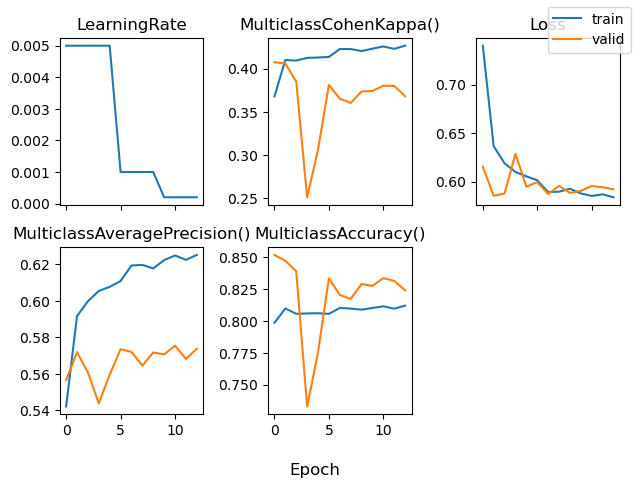

In [36]:
util.plot.plot_all_scalars_in_run(f"logs/{model_name}/history/")

Calculate performance on test set

In [37]:
from tqdm import tqdm
import pandas as pd

test_metrics = util.training.get_classif_metrics("multiclass", n_classes)

m.eval()
with torch.no_grad():
    for (X, y) in tqdm(test_loader, leave=False):
        y_hat = m(X)
        for metric in test_metrics:
            metric(y_hat, y)

for metric in test_metrics:
    print(f"{str(metric)}: {metric.compute():.3f}")

MulticlassAccuracy(): 0.827
MulticlassCohenKappa(): 0.310
MulticlassAveragePrecision(): 0.585


What if we test/validate on the smoothed signal?

In [38]:
valid_loader_ewma = DataLoader(
    valid_wds, 
    batch_size, 
    shuffle=True, 
    collate_fn=train_collator, 
    generator=torch.Generator(device=device)
)
test_loader_ewma  = DataLoader(
    test_wds, 
    batch_size, 
    shuffle=True, 
    collate_fn=train_collator, 
    generator=torch.Generator(device=device)
)

In [41]:
test_metrics_ewma = util.training.get_classif_metrics("multiclass", n_classes)

m.eval()
with torch.no_grad():
    for (X, y) in tqdm(test_loader_ewma, leave=False):
        y_hat = m(X)
        for metric in test_metrics_ewma:
            metric(y_hat, y)

for metric in test_metrics_ewma:
    print(f"{str(metric)}: {metric.compute():.3f}")

MulticlassAccuracy(): 0.827
MulticlassCohenKappa(): 0.310
MulticlassAveragePrecision(): 0.585


In [43]:
valid_metrics_ewma = util.training.get_classif_metrics("multiclass", n_classes)

m.eval()
with torch.no_grad():
    for (X, y) in tqdm(valid_loader_ewma, leave=False):
        y_hat = m(X)
        for metric in valid_metrics_ewma:
            metric(y_hat, y)

for metric in valid_metrics_ewma:
    print(f"{str(metric)}: {metric.compute():.3f}")

MulticlassAccuracy(): 0.824
MulticlassCohenKappa(): 0.368
MulticlassAveragePrecision(): 0.574


In [44]:
train_metrics = util.training.get_final_metrics(f"logs/{model_name}/history")

In [45]:
train_metrics

{'MulticlassAccuracy()/train': 0.8119419813156128,
 'MulticlassCohenKappa()/train': 0.4264070391654968,
 'MulticlassAveragePrecision()/train': 0.6251742243766785,
 'MulticlassAccuracy()/valid': 0.8239908218383789,
 'MulticlassCohenKappa()/valid': 0.3679119944572449,
 'MulticlassAveragePrecision()/valid': 0.5736441016197205,
 'Loss/train': 0.5837633013725281,
 'Loss/valid': 0.5919432044029236,
 'LearningRate': 0.00019999999494757503}

In [47]:
inference_window = dict(x=[8, False], y=[8, False], time=[4, False])
ds_infer = ds.sel(time=np.concatenate([valid_years, test_years]))
wds_infer = util.datasets.WindowXarrayDataset(
    ds_infer, window, 
    mask=ds_infer.sel(band="trend"), 
    na_thresh=0.5,
    downsample_step=8
)
print(len(wds_infer))

61294


In [48]:
ch_means = m.bn.running_mean

def inference_collator(patch):
    X = torch.tensor(
            np.squeeze(patch.values[:-1, input_inds, :, :]),
            dtype=dtype_x
        ).unsqueeze(0)

    # Replace nan cells with the channel mean
    X = torch.nan_to_num(X)
    X += m.bn.running_mean * torch.isnan(X)
    return X

In [49]:
out_arr = np.zeros(ds_infer.isel(band=0).shape)
out_n   = np.zeros(out_arr.shape)

with torch.no_grad():
    for i in tqdm(range(len(wds_infer))):
        input_tensor = inference_collator(wds_infer[i])
        t = wds_infer.valid_indices["time"][i]
        y = wds_infer.valid_indices["y"][i]
        x = wds_infer.valid_indices["x"][i]
    
        output_tensor = m(input_tensor).detach().numpy()
        # shift to [-1, 0, 1] to make these more additive
        output_classes = np.argmax(output_tensor[0], axis=0) - 1
    
        out_arr[t, y-7:y+1, x-7:x+1] += output_classes
        out_n[t, y-7:y+1, x-7:x+1] += 1

100%|██████████| 61294/61294 [02:47<00:00, 365.89it/s]


In [54]:
out_avg = out_arr / out_n
out_arr[out_n == 0] = np.nan

out_da = xr.DataArray(
    data=out_avg,
    dims=["time", "y", "x"],
    coords=dict(
        time=ds_infer.time,
        y=ds_infer.y,
        x=ds_infer.x
    )
)

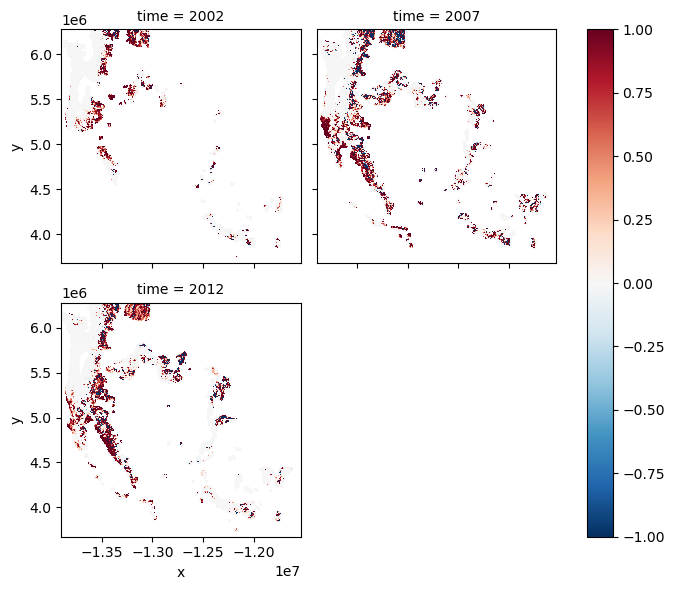

In [75]:
out_da.isel(time=[5, 10, 15]).plot(
    col="time", col_wrap=2,
)